In [1]:
# Numerical libraries
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# MD Stuff
import MDAnalysis as mda

# Utils
from tqdm import tqdm
import pickle
import os
import subprocess

# SBI
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


In [40]:
def write_param_file(fname, arg_dict):

    params_file = open(fname,"w")
    string = ""
    for key in arg_dict:

        string += f"{key} {arg_dict[key]}\n"
    
    params_file.write(string)
    params_file.close()

def simulate_for_sbi_cpp(indices, args_dict, n_ranks=1, n_threads=1, imgs_per_index=None):

    args = args_dict.copy()
    indices_copy = indices.clone().flatten()

    if imgs_per_index is None:

        indices_copy, ind_order = indices_copy.sort()
        ind_order = ind_order.argsort()

        indices_copy, imgs_per_index = indices_copy.flatten().round().int().unique(return_counts=True)
        n_total_images = indices.size()[0]

    else: 

        assert (indices_copy.sort()[0] == indices_copy.unique()).all(), "When using imgs_per_index indices must be unique"
        assert (indices_copy == indices_copy.int()).all(), "When using imgs_per_index all indices must be unique"

        indices_copy
        args["NUM_IMAGES"] = imgs_per_index
        n_total_images = imgs_per_index * indices_copy.size()[0]
    
    images = torch.empty((n_total_images, args_dict["N_PIXELS"]**2))
    image_counter = 0

    if os.path.isdir("tmp_images"):
        subprocess.run(["rm", "-r", "tmp_images/"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

    os.system("mkdir tmp_images")
    for counter, index in enumerate(tqdm(indices_copy)):

        args["STRUCTURE"] = f"models/state_1_{int(index)}.pdb"
        #args["IMG_PFX"] = f"cpp_images/img_state_1_{int(index)}_"
        args["IMG_PFX"] = "tmp_images/tmp_img_"

        if not isinstance(imgs_per_index, int):
            args["NUM_IMAGES"] = imgs_per_index[counter]

        write_param_file("config.txt", args)
        
        n_ranks_to_use = min(n_ranks, args["NUM_IMAGES"])
        subprocess.run(["mpirun", "-n", f"{n_ranks_to_use}", "./gen_img.out", "-ntomp", f"{n_threads}"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

        tmp_tensor = torch.empty((args["NUM_IMAGES"], args["N_PIXELS"]**2))
        for i in range(args["NUM_IMAGES"]):
            tmp_tensor[i] = torch.tensor(np.loadtxt(f"tmp_images/tmp_img_{i}.txt").flatten())

        images[image_counter:image_counter + args["NUM_IMAGES"]] = tmp_tensor
        image_counter += args["NUM_IMAGES"]

        subprocess.run(["rm", "tmp_images/tmp_img_*"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

    subprocess.run(["rm", "-r", "tmp_images/"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    subprocess.run(["rm", "config.txt"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    
    if not isinstance(imgs_per_index, int):
        images = images[ind_order]

        return indices, images

    else:
        ind_random = indices_copy.repeat_interleave(imgs_per_index) +\
            torch.rand(indices.shape[0] * imgs_per_index) - 0.499999

        shuffler = torch.randperm(ind_random.shape[0])

        ind_random = ind_random[shuffler].reshape(ind_random.shape[0], 1)
        images = images[shuffler]

        return ind_random, images

def add_noise(img, n_pixels, pixel_size, snr):

    img_noise = np.asarray(img).reshape(n_pixels, n_pixels)
    
    rad_sq = (pixel_size * (n_pixels + 1)*0.5)**2

    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    grid = np.arange(grid_min, grid_max, pixel_size)

    mask = grid[None,:]**2 + grid[:,None]**2 < rad_sq

    noise_std = np.std(img[mask]) / snr
    noise = np.random.normal(loc=0.0, scale = noise_std, size=img.shape)

    img_noise = img + noise

    return img_noise

def add_noise_to_dataset(dataset, args_dict, snr):

    images_with_noise = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        image_with_noise = add_noise(
            dataset[i].reshape(args_dict["N_PIXELS"], args_dict["N_PIXELS"]).numpy(),
            args_dict["N_PIXELS"],
            args_dict["PIXEL_SIZE"],
            snr)

        images_with_noise[i] = torch.tensor(image_with_noise.reshape(args_dict["N_PIXELS"]**2))

    return images_with_noise

def normalize_dataset(dataset):

    norm_images = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        mu = torch.mean(dataset[i])
        sigma = torch.std(dataset[i])

        norm_images[i] = (dataset[i] - mu) / sigma

    return norm_images

def apply_fft_dataset(dataset, n_pixels):

    images_fourier = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        image_fourier = np.abs(np.fft.fft2(dataset[i].reshape(n_pixels, n_pixels).numpy()))

        images_fourier[i] = torch.tensor(image_fourier.reshape(n_pixels**2))

    return images_fourier
    
    

# Generating data

I only generate images for models with name ```models/state_1_*.txt```. If you want to generate different models change the 43rd line in ```simulate_for_sbi_cpp``` (one cell above).

In [3]:
prior_indices = utils.BoxUniform(low=1*torch.ones(1), high=20*torch.ones(1))

In [4]:
args_dict = {"PIXEL_SIZE": 4.0,
             "N_PIXELS": 32,
             "SIGMA": 1.0,
             "CUTOFF": 3.0,
             "WITH_ROTATIONS": ""}

# Generate images (or load them if you already created them)
n_simulations = 100000
# indices = prior_indices.sample((n_simulations,))
# indices, images = simulate_for_sbi_cpp(indices, args_dict, n_ranks=4, n_threads=1)
# torch.save(indices, "indices_with_rot.pt")
# torch.save(images, "images_with_rot.pt")

# Uncomment an comment lines 5-11 if you already generated images
indices = torch.load("indices_with_rot.pt")
images = torch.load("images_with_rot.pt")

# THE WRAPPER IS 48x FASTER!!

# Post-processing of the generated images 

Because we are generating images with no rotations we need to add noise so pytorch doesn't die. This could also be the place to normalize images, or add the CTF. I prefer not to do add these things when generating the images because having a set of raw images allows me to do many test with just one dataset.

WARNING: with images without rotations the lack of noise kills PyTorch!

# Training SBI's neural network


In [5]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=10, num_transforms=4)
inference = SNPE(prior=prior_indices, density_estimator=density_estimator_build_fun)

In [41]:
# Calculate and save posterior
posteriors = {}
#snrs = [10, 1, 0.1, 0.01]
snrs = [0.1]

for snr in snrs:
    
    images_with_noise_fourier = add_noise_to_dataset(images, args_dict, snr) 
    images_with_noise_fourier = normalize_dataset(images_with_noise_fourier)
    images_with_noise_fourier = apply_fft_dataset(images_with_noise_fourier, args_dict["N_PIXELS"])
    
    inference = inference.append_simulations(indices, images_with_noise_fourier)
    density_estimator = inference.train()
    posteriors[f"snr_{snr}"] = inference.build_posterior(density_estimator)

/Data/Packages/Research/miniconda3/envs/sbi_cryoem/lib/python3.8/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 21 epochs.


In [23]:
with open("posteriors_with_rot.pkl", "wb") as handle:
    pickle.dump(posteriors, handle)

In [6]:
with open("posteriors_with_rot.pkl", "rb") as handle:
    posteriors = pickle.load(handle)

In [75]:
true_index = torch.tensor([1.3])
true_index, true_image = simulate_for_sbi_cpp(true_index, args_dict, n_ranks=1, n_threads=1)

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


In [76]:
n_samples = 20000

#snrs = [10, 1, 0.1, 0.01]
snrs = [0.1]
samples = torch.empty((len(snrs), n_samples, 1))

for i, snr in enumerate(snrs):
    
    #true_image_with_noise = add_noise_to_dataset(true_image, args_dict, snr) 
    #true_image_with_noise = normalize_dataset(true_image_with_noise)
    #true_image_with_noise = apply_fft_dataset(true_image_with_noise, args_dict["N_PIXELS"])

    #samples[i] = posteriors[f"snr_{0.1}"].sample((n_samples,), x=true_image_with_noise)  
    samples[i] = posteriors[f"snr_{0.1}"].sample((n_samples,), x=true_image)  

Drawing 20000 posterior samples: 27070it [00:00, 63153.98it/s]                           


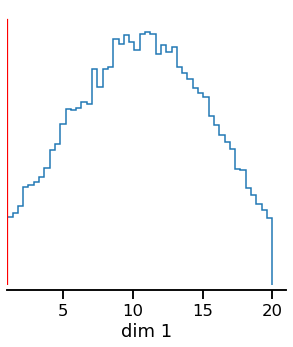

In [77]:
fig, axes = analysis.pairplot(samples[0],
                           limits=[[1,21], [1,21]],
                           #ticks=[[2,10], [2,10]],
                           figsize=(5,5),
                           points=true_index.round(),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

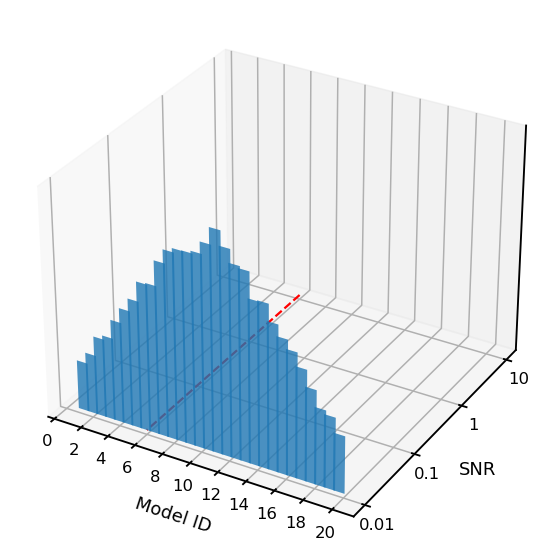

In [73]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("talk")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
nbins = 30

grid = np.arange((len(snrs) - 1)*10, -10, -10)

for i, z in enumerate(grid):
    
    hist, bins = np.histogram(samples[i].flatten().numpy(), bins=np.linspace(1, 20, nbins))
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', alpha=0.8)

ax.set_xlabel('Model ID', labelpad=15)
ax.set_ylabel('SNR', labelpad=15)

ax.set_xticks(range(0, 22, 2))
ax.set_yticks([30, 20, 10, 0])
ax.set_yticklabels(["10", "1", "0.1", "0.01"]);
ax.set_zticks([])

ax.plot([int(true_index), int(true_index)], [30, 0], [0, 0], ls="--", color="red")

In [71]:
np.arange((len(snrs) - 1)*10, -10, -10)

array([0])